In [3]:
import tensorflow as tf
import yfinance as yf
from yahoo_fin.stock_info import get_data
import pandas as pd
import numpy as np
import pandas_datareader
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [71]:
# Imports 3 years of BTC daily data from yahoo finance
BTC_df = get_data("BTC-USD", start_date="6/30/2019", end_date="06/30/2022", index_as_date = True, interval="1wk")
df = BTC_df.iloc[:,0:-1]
df.head()

,open,high,low,close,adjclose,volume
2019-06-24,11931.991211,12178.383789,10799.008789,10817.155273,10817.155273,27256473494
2019-07-01,10796.930664,12006.075195,9737.884766,11450.846680,11450.846680,181410821667
2019-07-08,11446.596680,13129.529297,10234.576172,10256.058594,10256.058594,180936684097
2019-07-15,10257.838867,11052.766602,9163.134766,10599.105469,10599.105469,157356814406
2019-07-22,10596.948242,10651.791016,9252.296875,9552.860352,9552.860352,112459229432


In [7]:
# Defines function to split X and y data
def window_data(df, window, feature_col_number, target_col_number):
    # Creates empty X and y list
    X = []
    y = []
    # loops through btc data
    for i in range(len(df) - window - 1):
        # splits the features by grouping window amount of previous close data
        features = df.iloc[i:(i + window), feature_col_number]
        # splits target by taking current close values
        target = df.iloc[(i + window), target_col_number]
        # Adds end of each loops data to respective X and y list
        X.append(features)
        y.append(target)
    # returns X,y as arrays
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:
# Defines window size
window_size=10

In [72]:
# Runs function to split X and y data
X, y=window_data(df, window_size, 3, 3)
# Displays X and y
display(X)
display(y)

array([[10817.15527344, 11450.84667969, 10256.05859375, ...,
        10345.81054688, 10138.51757812,  9757.97070312],
       [11450.84667969, 10256.05859375, 10599.10546875, ...,
        10138.51757812,  9757.97070312, 10441.27636719],
       [10256.05859375, 10599.10546875,  9552.86035156, ...,
         9757.97070312, 10441.27636719, 10347.71289062],
       ...,
       [46453.56640625, 42207.671875  , 39716.953125  , ...,
        30323.72265625, 29445.95703125, 29906.66210938],
       [42207.671875  , 39716.953125  , 39469.29296875, ...,
        29445.95703125, 29906.66210938, 26762.6484375 ],
       [39716.953125  , 39469.29296875, 38469.09375   , ...,
        29906.66210938, 26762.6484375 , 20553.27148438]])

array([[10441.27636719],
       [10347.71289062],
       [10070.39257812],
       [ 8104.18554688],
       [ 7988.15576172],
       [ 8321.00585938],
       [ 8222.078125  ],
       [ 9551.71484375],
       [ 9235.35449219],
       [ 9055.52636719],
       [ 8577.97558594],
       [ 7047.91699219],
       [ 7424.29248047],
       [ 7564.34521484],
       [ 7152.30175781],
       [ 7511.58886719],
       [ 7422.65283203],
       [ 7411.31738281],
       [ 8192.49414062],
       [ 8706.24511719],
       [ 8596.83007812],
       [ 9344.36523438],
       [10116.67382812],
       [ 9934.43359375],
       [ 9924.515625  ],
       [ 8562.45410156],
       [ 8108.11621094],
       [ 5392.31494141],
       [ 5830.25488281],
       [ 5922.04296875],
       [ 6791.12939453],
       [ 6971.09179688],
       [ 7189.42480469],
       [ 7679.8671875 ],
       [ 8897.46875   ],
       [ 8756.43066406],
       [ 9670.73925781],
       [ 8790.36816406],
       [ 9461.05859375],
       [ 9758.85253906],


In [73]:
# Scales X and y data using MinMaxScaler
X_scaler=MinMaxScaler()
X_scaler.fit(X)
X_scaled=X_scaler.transform(X)
y_scaler=MinMaxScaler()
y_scaler.fit(y)
y_scaled=y_scaler.transform(y)

In [74]:
# Defines where train and test data will be split (70% is train)
split=int(0.7*len(X_scaled))
# Splits train and test data
X_train=X_scaled[:split]
X_test=X_scaled[split:]
y_train=y_scaled[:split]
y_test=y_scaled[split:]

In [ ]:
#X_scaled=X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
#display(X.shape)

In [75]:
# Reshapes data into size LSTM can handle
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
display(X_train.shape)
display(X_test.shape)

(102, 10, 1)

(45, 10, 1)

In [76]:
# Creates neural network
model=Sequential()
# Defines and adds LSTM layer
first_lstm_layer=LSTM(units=30, return_sequences=True, input_shape=(window_size, 1))
model.add(first_lstm_layer)
# Randomly drops 20% of defined nodes
first_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model.add(first_dropout_layer)
second_lstm_layer=LSTM(units=30, return_sequences=True)
model.add(second_lstm_layer)
# Randomly drops 20% of defined nodes
second_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model.add(second_dropout_layer)
third_lstm_layer=LSTM(units=30)
model.add(third_lstm_layer)
# Defines and adds output layer with linear activation
output_layer=Dense(units=1, activation='linear')
model.add(output_layer)

In [77]:
# Compiles model
model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [78]:
# Provides summary of model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 10, 30)            3840      
                                                                 
 dropout_6 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_10 (LSTM)              (None, 10, 30)            7320      
                                                                 
 dropout_7 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_11 (LSTM)              (None, 30)                7320      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trai

In [79]:
# Initially fits model using training data
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
4/4 [==============================] - 8s 23ms/step - loss: 0.1429 - mean_squared_error: 0.1429
Epoch 2/50
4/4 [==============================] - 0s 38ms/step - loss: 0.1055 - mean_squared_error: 0.1055
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 0.0673 - mean_squared_error: 0.0673
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 0.0427 - mean_squared_error: 0.0427
Epoch 5/50
4/4 [==============================] - 0s 23ms/step - loss: 0.0419 - mean_squared_error: 0.0419
Epoch 6/50
4/4 [==============================] - 0s 19ms/step - loss: 0.0365 - mean_squared_error: 0.0365
Epoch 7/50
4/4 [==============================] - 0s 19ms/step - loss: 0.0296 - mean_squared_error: 0.0296
Epoch 8/50
4/4 [==============================] - 0s 19ms/step - loss: 0.0257 - mean_squared_error: 0.0257
Epoch 9/50
4/4 [==============================] - 0s 21ms/step - loss: 0.0243 - mean_squared_error: 0.0243
Epoch 10/50
4/4 [====================

In [80]:
# Projects future data by using model to predict next close and then uses that value to retrain 
# the model before making next prediction
for i in range(56): 
    # predicts next close value and reshapes it
    prediction_scaled=model.predict(X_train[-1].reshape(1, window_size, 1))
    # transforms prediction back to original scale
    next_prediction=y_scaler.inverse_transform(prediction_scaled)
    # displays predicted close value
    display(next_prediction)
    # adds predicted close value to list
    new_train_sample=np.append(X_train[-1], prediction_scaled)[1:].reshape(1, window_size, 1)
    # adds new list entry of predicted close to X train
    X_train=np.append(X_train, new_train_sample, axis=0)
    # adds new list entry of predicted close to y train
    y_train=np.append(y_train, prediction_scaled, axis=0)
    # refits model with new close value
    model.fit(X_train, y_train, epochs=5)

1/1 [==============================] - 2s 2s/step


array([[49319.79]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 27ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 2/5
4/4 [==============================] - 0s 28ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 3/5
4/4 [==============================] - 0s 31ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 4/5
4/4 [==============================] - 0s 31ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[48534.02]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 3/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 4/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[45643.42]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 3/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 4/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[50823.363]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 2/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 3/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 4/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[47245.37]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 3/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[50811.555]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 2/5
4/4 [==============================] - 0s 21ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 3/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 4/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[52866.414]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 3/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 4/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[49551.97]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 3/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 4/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[48833.74]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 3/5
4/4 [==============================] - 0s 21ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 4/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[50507.484]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 3/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 4/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[46043.418]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 2/5
4/4 [==============================] - 0s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 3/5
4/4 [==============================] - 0s 24ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 4/5
4/4 [==============================] - 0s 26ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[46579.285]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 27ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 3/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 4/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[49901.27]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 2/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 3/5
4/4 [==============================] - 0s 25ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 4/5
4/4 [==============================] - 0s 24ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[43928.21]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 2/5
4/4 [==============================] - 0s 22ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 3/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 4/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[44016.742]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 2/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 3/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 4/5
4/4 [==============================] - 0s 21ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[42640.24]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 26ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 2/5
4/4 [==============================] - 0s 24ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 3/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 4/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[44009.582]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 23ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 3/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[43257.42]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 3/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/5
4/4 [==============================] - 0s 21ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[42298.94]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 3/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[44036.598]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 3/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 4/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[45546.094]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 2/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 3/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 4/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[43552.254]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 21ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 2/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 3/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 4/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[45722.805]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 2/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 3/5
4/4 [==============================] - 0s 21ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[44446.797]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 3/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 4/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[48033.344]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 20ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 3/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/5
4/4 [==============================] - 0s 19ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[47077.664]], dtype=float32)

Epoch 1/5
4/4 [==============================] - 0s 18ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 2/5
4/4 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 3/5
4/4 [==============================] - 0s 17ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 4/5
4/4 [==============================] - 0s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[46758.418]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 3/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45414.137]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 3/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 4/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[46111.035]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47905.59]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 2/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 3/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[44899.414]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 2/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 3/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 4/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[46469.598]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 2/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[45627.133]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 3/5
5/5 [==============================] - 0s 23ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 4/5
5/5 [==============================] - 0s 21ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[45503.395]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 2/5
5/5 [==============================] - 0s 20ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[46311.535]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[46140.145]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 2/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 3/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[46237.145]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 2/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47053.426]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[45824.85]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45860.66]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[46037.906]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[46590.31]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 2/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[45643.395]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45927.504]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 4/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45234.25]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 2/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45506.51]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[46293.848]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[44923.918]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2/5
5/5 [==============================] - 0s 22ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 4/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[45338.38]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 2/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 5/5
1/1 [==============================] - 0s 45ms/step


array([[46922.047]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 2/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45359.16]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[45750.477]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 2/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 4/5
5/5 [==============================] - 0s 21ms/step - loss: 0.0025 - mean_squared_error: 0.0025 
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45838.73]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 2/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[45703.39]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 4/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[47068.453]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 2/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 4/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[46799.95]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 3/5
5/5 [==============================] - 0s 17ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 4/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 5/5
5/5 [==============================] - 0s 16ms/step - loss: 0.0025 - mean_squared_error: 0.0025


In [81]:
# predicts next close values
prediction = model.predict(X_test)
# rescales predicted values to original scale
y_predicted=y_scaler.inverse_transform(prediction)

2/2 [==============================] - 0s 7ms/step


In [82]:
len(df['close'])-61

97

In [84]:
comparison_df = pd.DataFrame({'predictions':y_predicted.ravel(),'actual':df.iloc[113:]['close']})
comparison_df
#display(y_predicted)
#display(df.iloc[760:]['close'])

,predictions,actual
2021-08-23,44608.539062,48829.832031
2021-08-30,47872.625000,51753.410156
2021-09-06,50690.765625,46063.269531
2021-09-13,52972.746094,47260.218750
2021-09-20,54122.980469,43208.539062
2021-09-27,53600.910156,48199.953125
2021-10-04,50981.308594,54771.578125
2021-10-11,48197.414062,61553.617188
2021-10-18,46554.300781,60930.835938
2021-10-25,46821.140625,61318.957031


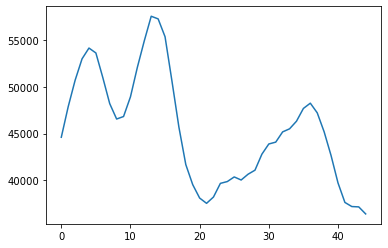

In [85]:
# Plots the predicted test values
plt.plot(y_predicted)
# Plots the true historic close values

(array([18871., 18901., 18932., 18962., 18993., 19024., 19052., 19083.,
        19113., 19144., 19174.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

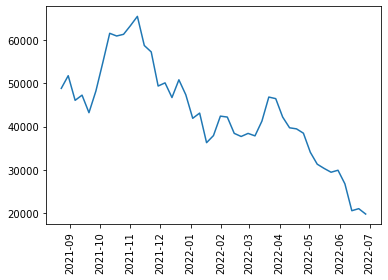

In [86]:
# Plots the true historic close values
plt.plot(df.iloc[113:]['close'])
# Rotates X labels
plt.xticks(rotation = 90)

In [ ]:
y[-326]

In [29]:
# Begins Future Projections Section

In [30]:
# Creates neural network
model_prediction_btc=Sequential()
# Defines and adds LSTM layer
first_lstm_layer=LSTM(units=30, return_sequences=True, input_shape=(window_size, 1))
model_prediction_btc.add(first_lstm_layer)
# Randomly drops 20% of defined nodes
first_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model_prediction_btc.add(first_dropout_layer)
second_lstm_layer=LSTM(units=30, return_sequences=True)
model_prediction_btc.add(second_lstm_layer)
# Randomly drops 20% of defined nodes
second_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model_prediction_btc.add(second_dropout_layer)
third_lstm_layer=LSTM(units=30)
model_prediction_btc.add(third_lstm_layer)
# Defines and adds output layer with linear activation
output_layer=Dense(units=1, activation='linear')
model_prediction_btc.add(output_layer)

In [31]:
# Compiles model
model_prediction_btc.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [32]:
# Provides summary of model
model_prediction_btc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 30)            3840      
                                                                 
 dropout_2 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 30)            7320      
                                                                 
 dropout_3 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_5 (LSTM)               (None, 30)                7320      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trai

In [33]:
X_scaled=X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
display(X.shape)

(147, 10)

In [34]:
# Initially fits model using training data
model_prediction_btc.fit(X_scaled, y_scaled, epochs=50)

Epoch 1/50
5/5 [==============================] - 7s 23ms/step - loss: 0.2274 - mean_squared_error: 0.2274
Epoch 2/50
5/5 [==============================] - 0s 55ms/step - loss: 0.1330 - mean_squared_error: 0.1330
Epoch 3/50
5/5 [==============================] - 0s 40ms/step - loss: 0.0581 - mean_squared_error: 0.0581
Epoch 4/50
5/5 [==============================] - 0s 26ms/step - loss: 0.0432 - mean_squared_error: 0.0432
Epoch 5/50
5/5 [==============================] - 0s 34ms/step - loss: 0.0459 - mean_squared_error: 0.0459
Epoch 6/50
5/5 [==============================] - 0s 27ms/step - loss: 0.0300 - mean_squared_error: 0.0300
Epoch 7/50
5/5 [==============================] - 0s 40ms/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0285 - mean_squared_error: 0.0285
Epoch 9/50
5/5 [==============================] - 0s 33ms/step - loss: 0.0262 - mean_squared_error: 0.0262
Epoch 10/50
5/5 [====================

In [36]:
# Projects future data by using model to predict next close and then uses that value to retrain 
# the model before making next prediction
# Creates empty list where future predictions will be added to
future_predictions = []
for i in range(56): 
    # predicts next close value and reshapes it
    prediction_scaled=model_prediction_btc.predict(X_scaled[-1].reshape(1, window_size, 1))
    # transforms prediction back to original scale
    next_prediction=y_scaler.inverse_transform(prediction_scaled)
    # displays predicted close value
    display(next_prediction)
    # Adds future predictions to list
    future_predictions.append(next_prediction)
    # adds predicted close value to list
    new_train_sample=np.append(X_scaled[-1], prediction_scaled)[1:].reshape(1, window_size, 1)
    # adds new list entry of predicted close to X train
    X_scaled=np.append(X_scaled, new_train_sample, axis=0)
    # adds new list entry of predicted close to y train
    y_scaled=np.append(y_scaled, prediction_scaled, axis=0)
    # refits model with new close value
    model_prediction_btc.fit(X_scaled, y_scaled, epochs=5)

1/1 [==============================] - 2s 2s/step


array([[34395.242]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 20ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 2/5
5/5 [==============================] - 0s 20ms/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 3/5
5/5 [==============================] - 0s 22ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 4/5
5/5 [==============================] - 0s 71ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 5/5
1/1 [==============================] - 0s 78ms/step


array([[35883.684]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 25ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 2/5
5/5 [==============================] - 0s 24ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 3/5
5/5 [==============================] - 0s 24ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 4/5
5/5 [==============================] - 0s 23ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 5/5
1/1 [==============================] - 0s 60ms/step


array([[33634.066]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 20ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 2/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 3/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 4/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[34579.996]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 2/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 3/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 4/5
5/5 [==============================] - 0s 20ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[36520.535]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 23ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 2/5
5/5 [==============================] - 0s 30ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 3/5
5/5 [==============================] - 0s 23ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 4/5
5/5 [==============================] - 0s 20ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[38085.023]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 2/5
5/5 [==============================] - 0s 23ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 3/5
5/5 [==============================] - 0s 21ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[38111.633]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 20ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 2/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 3/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[40913.527]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 2/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 4/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[42652.168]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 2/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 3/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 4/5
5/5 [==============================] - 0s 20ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[44795.2]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 2/5
5/5 [==============================] - 0s 18ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 3/5
5/5 [==============================] - 0s 20ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 4/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[45660.87]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 30ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 2/5
5/5 [==============================] - 0s 23ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 3/5
5/5 [==============================] - 0s 20ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 4/5
5/5 [==============================] - 0s 24ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 5/5
1/1 [==============================] - 0s 55ms/step


array([[46404.445]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 25ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 2/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 3/5
5/5 [==============================] - 0s 21ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 4/5
5/5 [==============================] - 0s 19ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[45987.57]], dtype=float32)

Epoch 1/5
5/5 [==============================] - 0s 39ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 2/5
5/5 [==============================] - 0s 37ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 3/5
5/5 [==============================] - 0s 30ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 4/5
5/5 [==============================] - 0s 30ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[48629.902]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 3/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 4/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


array([[48659.77]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 24ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 2/5
6/6 [==============================] - 0s 24ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 3/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[48891.473]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 21ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 3/5
6/6 [==============================] - 0s 24ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 4/5
6/6 [==============================] - 0s 24ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[50187.414]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 2/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 3/5
6/6 [==============================] - 0s 22ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 4/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[48362.188]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 3/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[48912.184]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 3/5
6/6 [==============================] - 0s 21ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 4/5
6/6 [==============================] - 0s 21ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[49345.86]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 21ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[49870.895]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 21ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 2/5
6/6 [==============================] - 0s 24ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 3/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 4/5
6/6 [==============================] - 0s 21ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 5/5
1/1 [==============================] - 0s 21ms/step


array([[47608.543]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 21ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 2/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


array([[47911.582]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 2/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 4/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[48173.11]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 21ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 2/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 3/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 4/5
6/6 [==============================] - 0s 21ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[46282.082]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 24ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 2/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 3/5
6/6 [==============================] - 0s 22ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[46633.375]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 2/5
6/6 [==============================] - 0s 22ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 3/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 4/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45868.89]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 2/5
6/6 [==============================] - 0s 41ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 3/5
6/6 [==============================] - 0s 25ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 4/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[46149.707]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 2/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 3/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45551.414]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 5/5
1/1 [==============================] - 0s 43ms/step


array([[45702.15]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 21ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 2/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 3/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 4/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[44354.316]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[44017.69]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 3/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[42941.027]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 21ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 2/5
6/6 [==============================] - 0s 25ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 3/5
6/6 [==============================] - 0s 21ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 4/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[43390.816]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 23ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 2/5
6/6 [==============================] - 0s 28ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 3/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 4/5
6/6 [==============================] - 0s 20ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[43533.055]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 24ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 2/5
6/6 [==============================] - 0s 28ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 3/5
6/6 [==============================] - 0s 35ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 4/5
6/6 [==============================] - 0s 27ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[42689.8]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 3/5
6/6 [==============================] - 0s 41ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 5/5
1/1 [==============================] - 0s 32ms/step


array([[42851.555]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[43354.01]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[43778.895]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[45042.574]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 2/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[44725.746]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 4/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[44443.027]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[45399.758]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[44837.363]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 3/5
6/6 [==============================] - 0s 18ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[45912.42]], dtype=float32)

Epoch 1/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 2/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 3/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 4/5
6/6 [==============================] - 0s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[46744.418]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 4/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[46787.387]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47881.168]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[44074.906]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 2/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[46901.39]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 4/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[46787.38]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 2/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45705.21]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 4/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[45812.65]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 2/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 4/5
7/7 [==============================] - 0s 20ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 5/5
1/1 [==============================] - 0s 39ms/step


array([[46964.8]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 24ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2/5
7/7 [==============================] - 0s 24ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 3/5
7/7 [==============================] - 0s 22ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 4/5
7/7 [==============================] - 0s 26ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 5/5
1/1 [==============================] - 0s 76ms/step


array([[44508.266]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 35ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 2/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 3/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 5/5
1/1 [==============================] - 0s 36ms/step


array([[45364.8]], dtype=float32)

Epoch 1/5
7/7 [==============================] - 0s 21ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2/5
7/7 [==============================] - 0s 34ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 5/5
7/7 [==============================] - 0s 20ms/step - loss: 0.0045 - mean_squared_error: 0.0045


In [46]:
future_predictions

[array([[34395.242]], dtype=float32),
 array([[35883.684]], dtype=float32),
 array([[33634.066]], dtype=float32),
 array([[34579.996]], dtype=float32),
 array([[36520.535]], dtype=float32),
 array([[38085.023]], dtype=float32),
 array([[38111.633]], dtype=float32),
 array([[40913.527]], dtype=float32),
 array([[42652.168]], dtype=float32),
 array([[44795.2]], dtype=float32),
 array([[45660.87]], dtype=float32),
 array([[46404.445]], dtype=float32),
 array([[45987.57]], dtype=float32),
 array([[48629.902]], dtype=float32),
 array([[48659.77]], dtype=float32),
 array([[48891.473]], dtype=float32),
 array([[50187.414]], dtype=float32),
 array([[48362.188]], dtype=float32),
 array([[48912.184]], dtype=float32),
 array([[49345.86]], dtype=float32),
 array([[49870.895]], dtype=float32),
 array([[47608.543]], dtype=float32),
 array([[47911.582]], dtype=float32),
 array([[48173.11]], dtype=float32),
 array([[46282.082]], dtype=float32),
 array([[46633.375]], dtype=float32),
 array([[45868.89]]

In [37]:
# df.index+
future_dates=pd.date_range(df.index[-1], periods=56, freq='W')
datetime_index=df.index.append(future_dates)
datetime_index.values

array(['2019-06-24T00:00:00.000000000', '2019-07-01T00:00:00.000000000',
       '2019-07-08T00:00:00.000000000', '2019-07-15T00:00:00.000000000',
       '2019-07-22T00:00:00.000000000', '2019-07-29T00:00:00.000000000',
       '2019-08-05T00:00:00.000000000', '2019-08-12T00:00:00.000000000',
       '2019-08-19T00:00:00.000000000', '2019-08-26T00:00:00.000000000',
       '2019-09-02T00:00:00.000000000', '2019-09-09T00:00:00.000000000',
       '2019-09-16T00:00:00.000000000', '2019-09-23T00:00:00.000000000',
       '2019-09-30T00:00:00.000000000', '2019-10-07T00:00:00.000000000',
       '2019-10-14T00:00:00.000000000', '2019-10-21T00:00:00.000000000',
       '2019-10-28T00:00:00.000000000', '2019-11-04T00:00:00.000000000',
       '2019-11-11T00:00:00.000000000', '2019-11-18T00:00:00.000000000',
       '2019-11-25T00:00:00.000000000', '2019-12-02T00:00:00.000000000',
       '2019-12-09T00:00:00.000000000', '2019-12-16T00:00:00.000000000',
       '2019-12-23T00:00:00.000000000', '2019-12-30

(array([18078., 18262., 18444., 18628., 18809., 18993., 19174., 19358.,
        19539.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

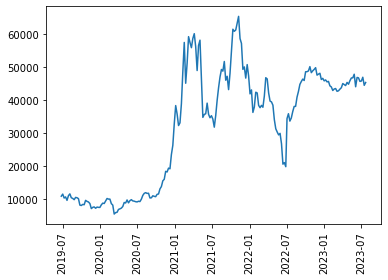

In [45]:
plt.plot(datetime_index.values, np.concatenate((df['close'].values, np.array(future_predictions).ravel())))
plt.xticks(rotation=90)

In [ ]:
# Imports 3 years of BTC daily data from yahoo finance
Dodge_df = get_data("DOGE-USD", start_date="6/30/2019", end_date="06/30/2022", index_as_date = True, interval="1d")
df = Dodge_df.iloc[:,0:-1]
df.head()

In [ ]:
# Defines function to split X and y data
def window_data(df, window, feature_col_number, target_col_number):
    # Creates empty X and y list
    X = []
    y = []
    # loops through btc data
    for i in range(len(df) - window - 1):
        # splits the features by grouping window amount of previous close data
        features = df.iloc[i:(i + window), feature_col_number]
        # splits target by taking current close values
        target = df.iloc[(i + window), target_col_number]
        # Adds end of each loops data to respective X and y list
        X.append(features)
        y.append(target)
    # returns X,y as arrays
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
# Defines window size
window_size=10

In [ ]:
# Runs function to split X and y data
X, y=window_data(df, window_size, 3, 3)
# Displays X and y
display(X)
display(y)

In [ ]:
# Scales X and y data using MinMaxScaler
X_scaler=MinMaxScaler()
X_scaler.fit(X)
X_scaled=X_scaler.transform(X)
y_scaler=MinMaxScaler()
y_scaler.fit(y)
y_scaled=y_scaler.transform(y)

In [ ]:
# Defines where train and test data will be split (70% is train)
split=int(0.7*len(X_scaled))
# Splits train and test data
X_train=X_scaled[:split]
X_test=X_scaled[split:]
y_train=y_scaled[:split]
y_test=y_scaled[split:]

In [ ]:
# Reshapes data into size LSTM can handle
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
display(X_train.shape)
display(X_test.shape)

In [ ]:
# Creates neural network
model_doge=Sequential()
# Defines and adds LSTM layer
first_lstm_layer=LSTM(units=30, return_sequences=True, input_shape=(window_size, 1))
model_doge.add(first_lstm_layer)
# Randomly drops 20% of defined nodes
first_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model_doge.add(first_dropout_layer)
second_lstm_layer=LSTM(units=30, return_sequences=True)
model_doge.add(second_lstm_layer)
# Randomly drops 20% of defined nodes
second_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model_doge.add(second_dropout_layer)
third_lstm_layer=LSTM(units=30)
model_doge.add(third_lstm_layer)
# Defines and adds output layer with linear activation
output_layer=Dense(units=1, activation='linear')
model_doge.add(output_layer)

In [ ]:
# Compiles model
model_doge.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [ ]:
# Provides summary of model
model_doge.summary()

In [ ]:
# Initially fits model using training data
model_doge.fit(X_train, y_train, epochs=50)

In [ ]:
# Projects future data by using model to predict next close and then uses that value to retrain 
# the model before making next prediction
for i in range(326): 
    # predicts next close value and reshapes it
    prediction_scaled=model.predict(X_train[-1].reshape(1, window_size, 1))
    # transforms prediction back to original scale
    next_prediction=y_scaler.inverse_transform(prediction_scaled)
    # displays predicted close value
    display(next_prediction)
    # adds predicted close value to list
    new_train_sample=np.append(X_train[-1], prediction_scaled)[1:].reshape(1, window_size, 1)
    # adds new list entry of predicted close to X train
    X_train=np.append(X_train, new_train_sample, axis=0)
    # adds new list entry of predicted close to y train
    y_train=np.append(y_train, prediction_scaled, axis=0)
    # refits model with new close value
    model_doge.fit(X_train, y_train, epochs=5)

In [ ]:
# predicts next close values
prediction = model_doge.predict(X_test)
# rescales predicted values to original scale
y_predicted=y_scaler.inverse_transform(prediction)

In [ ]:
comparison_df = pd.DataFrame({'predictions':y_predicted.ravel(),'actual':df.iloc[771:]['close']})
comparison_df
#display(y_predicted)
#display(df.iloc[760:]['close'])

In [ ]:
# Plots the predicted test values
plt.plot(y_predicted)
# Plots the true historic close values

In [ ]:
# Plots the true historic close values
plt.plot(df.iloc[760:]['close'])

In [ ]:
y[-326]

In [4]:
#Bitcoin weekly
BTC_df_week = get_data("BTC-USD", start_date="6/30/2019", end_date="06/30/2022", index_as_date = True, interval="1d")
pandas_datareader.yahoo.daily.YahooDailyReader(t, interval='w' , start='2015-1-1').read()['Adj Close']
df.head()

NameError: name 't' is not defined

In [ ]:
df.plot()